In [ ]:
import pandas as pd
import numpy as np
import os, sys
import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from utils.smarts_manipulation import get_smi_prod
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from math import sqrt

from dft_res_utils import compute_r1_r2, gen_feature_df_paral, judge_type

NameError: name '__file__' is not defined

In [2]:
# uncomment on following spe_filename specification lines for using recalculated SPE values
spe_filename = "" 

# CKAs dataset
merged_df = pd.read_csv('wb97_DFT_res/CKAS_cappingC.csv').drop(columns=['No.'])
exp_worksheet = pd.read_csv('data/CKAs.csv')
capping_group = "[*]C"
# spe_filename = "wb97_DFT_res/wb97x2d_CKAs_spe.csv"
# spe_filename = "wb97_DFT_res/ccsdt_CKAs_spe.csv"

# # Principles of Polymerization textbook dataset
# merged_df = pd.read_csv('wb97_DFT_res/textbook_cappingC.csv').drop(columns=['No.'])
# exp_worksheet = pd.read_csv('data/textbook_monomer_react_ratio_smarts.csv')
# capping_group = "[*]C"
# spe_filename = "wb97_DFT_res/wb97x2d_textbook_spe.csv"

if os.path.exists(spe_filename):
    spe_df = pd.read_csv(spe_filename)
    if 'No.' in spe_df.columns:
        spe_df = spe_df.drop(columns=['No.'])
    # substitute ['SPE[au]'] col in merged_df with spe_df['SPE[au]'] according to the 'Name'
    merged_df.drop(columns=['SPE[au]'], inplace=True, errors='ignore')
    merged_df = merged_df.merge(spe_df[['Name', 'SPE[au]']], on='Name', how='left')


In [3]:
print(f"Before dropping duplicates: {merged_df.shape[0]} rows")

# drop NAN rows, if any NAN in the row, drop the row
merged_df = merged_df.dropna(how='any')

print(f"After dropping NAN rows: {merged_df.shape[0]} rows")

capping_name = capping_group.replace("*", "").replace("[", "").replace("]", "")
r_low, r_high = 0.001, 50.

Before dropping duplicates: 84 rows
After dropping NAN rows: 84 rows


In [4]:
final_df = gen_feature_df_paral(exp_worksheet, merged_df,
                                feature_list=['Hcorr[au]', 'SPE[au]', 'TS[au]', 'ZPE[au]'],
                                capping_group=capping_group,
                                expected_mol_num=12)
final_df.head(3)

100%|██████████| 10/10 [00:00<00:00, 57456.22it/s]

num of success: 10
num of error: 0


,Monomer_1,Monomer_2,r1,r2,T,mol1_Hcorr[au],mol1_SPE[au],mol1_TS[au],mol1_ZPE[au],mol2_Hcorr[au],...,sm12_TS[au],sm12_ZPE[au],sm21_Hcorr[au],sm21_SPE[au],sm21_TS[au],sm21_ZPE[au],sm22_Hcorr[au],sm22_SPE[au],sm22_TS[au],sm22_ZPE[au]
0,MDPL,MMA,0.0140,3.551,363,0.190508,-537.555177,0.045835,0.179857,0.133094,...,0.073600,0.341620,0.366241,-923.294009,0.073043,0.343348,0.308730,-731.571106,0.068194,0.287667
1,MDPL,NEtMI,0.0210,0.157,343,0.190508,-537.555177,0.045835,0.179857,0.135232,...,0.075840,0.343234,0.367996,-1015.587548,0.072679,0.345144,0.312808,-916.147722,0.069644,0.291414
2,GMA,MDO,4.2351,0.155,333,0.175061,-498.449219,0.047501,0.163528,0.164724,...,0.072959,0.359609,0.382614,-923.472998,0.072959,0.359609,0.392735,-1036.812695,0.080733,0.366407


In [5]:
filtered_result_df = final_df.groupby(['Monomer_1', 'Monomer_2']).agg({
    feature: 'mean' for feature in final_df.columns if feature not in ['Monomer_1', 'Monomer_2',]
}).reset_index()
filtered_result_df.head(3)

,Monomer_1,Monomer_2,r1,r2,T,mol1_Hcorr[au],mol1_SPE[au],mol1_TS[au],mol1_ZPE[au],mol2_Hcorr[au],...,sm12_TS[au],sm12_ZPE[au],sm21_Hcorr[au],sm21_SPE[au],sm21_TS[au],sm21_ZPE[au],sm22_Hcorr[au],sm22_SPE[au],sm22_TS[au],sm22_ZPE[au]
0,BMDO,HEMA-TMS,0.0190,4.692,343.0,0.190862,-537.547918,0.044478,0.180616,0.278393,...,0.093589,0.476546,0.511923,-1446.585370,0.090566,0.479749,0.599286,-1778.154521,0.107665,0.558748
1,BMDO,MMA,0.5030,1.950,393.0,0.190862,-537.547918,0.044478,0.180616,0.133094,...,0.074131,0.341030,0.366473,-923.285647,0.073265,0.343755,0.308730,-731.571106,0.068194,0.287667
2,GMA,MDO,4.2351,0.155,333.0,0.175061,-498.449219,0.047501,0.163528,0.164724,...,0.072959,0.359609,0.382614,-923.472998,0.072959,0.359609,0.392735,-1036.812695,0.080733,0.366407


In [6]:
ZPE_corr = .9750 # wB97XD, def2-TZVP, Trular
compute_r1_r2_zpe_corr = partial(compute_r1_r2, ZPE_corr=ZPE_corr)

# compute r1 and r2 predicted value for each row
filtered_result_df['r1_pred'], filtered_result_df['r2_pred'] = zip(
    *filtered_result_df.apply(compute_r1_r2_zpe_corr, axis=1))

# squeeze predicted r to r_min and r_max
filtered_result_df['r1_pred'] = filtered_result_df[
    'r1_pred'].clip(lower=r_low, upper=r_high)
filtered_result_df['r2_pred'] = filtered_result_df[
    'r2_pred'].clip(lower=r_low, upper=r_high)
filtered_result_df.dropna(how='any', inplace=True)
filtered_result_df = filtered_result_df.reset_index(drop=True)

In [7]:
logr_value_array = np.log(np.maximum(
    r_low, pd.concat([filtered_result_df['r1'], filtered_result_df['r2']])))
pred_logr_value_array = np.log(np.maximum(
    r_low, pd.concat([filtered_result_df['r1_pred'], 
                      filtered_result_df['r2_pred']])))

# Compute RMSE, MAE, and R-squared
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
rmse = sqrt(mean_squared_error(logr_value_array, pred_logr_value_array))
mae = mean_absolute_error(logr_value_array, pred_logr_value_array)
r_squared = r2_score(logr_value_array, pred_logr_value_array)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r_squared:.3f}")

RMSE: 2.78
MAE: 2.29
R-squared: -0.380


In [8]:
pred_r_value_array = np.exp(pred_logr_value_array.values)
r_value_array = np.exp(logr_value_array.values)

pred_label = np.array(list(map(
    judge_type, np.concatenate(
        [pred_r_value_array[:pred_r_value_array.shape[0]//2][:,None], pred_r_value_array[pred_r_value_array.shape[0]//2:][:,None]],
        axis=1).tolist())))
true_label = np.array(list(map(
    judge_type, np.concatenate(
        [r_value_array[:r_value_array.shape[0]//2][:, None], r_value_array[r_value_array.shape[0]//2:][:, None]],
        axis=1).tolist())))

In [9]:
accuracy = np.sum(pred_label == true_label) / len(true_label)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import f1_score
f1 = f1_score(pred_label, true_label, average='weighted')
print(f"test F1 score: {f1:.4f}")

Accuracy: 0.3000
test F1 score: 0.3000


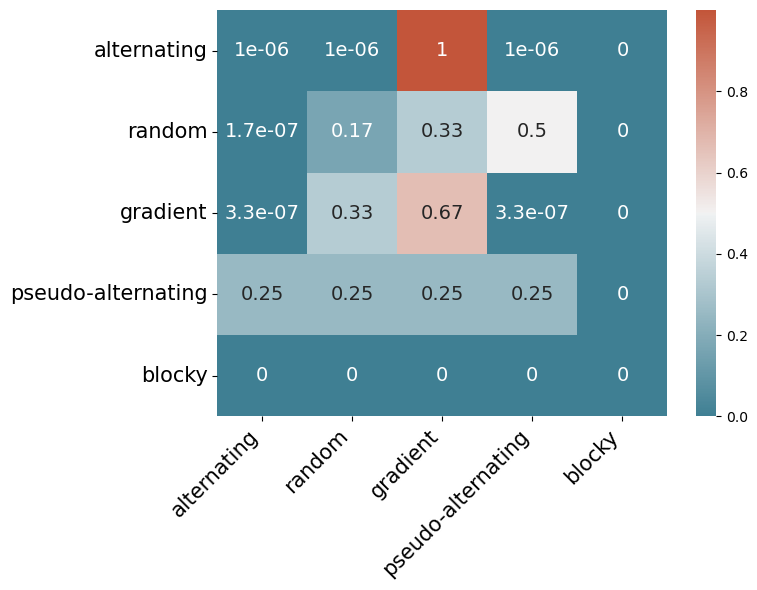

In [10]:
from dft_res_utils import plot_confusion_matrix

type2label = {"alternating":0, "random":1, "gradient":2, "pseudo-alternating":3, "blocky":4 }

plot_confusion_matrix(true_label, pred_label, fig_name="")

In [11]:
true_label_list = true_label.tolist()

label2type = {
    0: "alternating",
    1: "random",
    2: "gradient",
    3: "pseudo-alternating",
    4: "blocky"
}
type_num_list = []
for label in set(true_label_list):
    type_ = label2type[label]
    print(f"label: {type_}")
    print(f"num of {type_}: {true_label_list.count(label)}")
    type_num_list.append(true_label_list.count(label))
    print("=========================================")

label: alternating
num of alternating: 1
label: gradient
num of gradient: 6
label: pseudo-alternating
num of pseudo-alternating: 3
